In [1]:
using OrdinaryDiffEq
using Plots
using Random
using Optim
using LaTeXStrings
using BenchmarkTools

rng = Xoshiro(14588); # set random number generator seed

We consider the follow pendulum model $$\frac{\mathrm{d}}{\mathrm{d}t}x(t)=\begin{bmatrix}\dot{\theta}(t)\\ \ddot{\theta}(t)\end{bmatrix}=\begin{bmatrix}x_2(t)\\ -\frac{g}{L}\sin(x_1(t))-\frac{b}{m}x_2(t)\end{bmatrix}$$
with the states $x(t)=\begin{bmatrix}\theta & \dot{\theta} \end{bmatrix}^\mathrm{T}$ being the angular position $\theta$ and the angular velocity $\dot{\theta}$. The model is parametrized via $$p = \begin{bmatrix}g \\ L \\ b \\ m \end{bmatrix}$$ which refers to the standard acceleration of gravity, the pendulum length, the friction coefficient and the pendulum's bob mass.  



In the following, we will first generate some 'experimental' data using noisy sensor measurements of a parametrized simulation model and then apply parameter identification assuming that we only have partial model knowledge. 

In [2]:
# Model parameters defined as constants
const g = 9.81 # gravity constant
const L = 1.0 # length of pendulum
const b = 0.25 # damping coefficient
const m = 0.5 # mass of pendulum

0.5

In [3]:
#Initial condition and simulation time span
const x0 = [0,π/2]
const tspan = (0.0,4)

(0.0, 4)

In [4]:
#Define the ODE model as a function which can be passed to a solver
function simplependulum!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - b/m*x[2]
    nothing
end

simplependulum! (generic function with 1 method)

To solve the ODE and generate some ground truth data we will make use of the [OrdinaryDiffEq.jl](https://github.com/SciML/OrdinaryDiffEq.jl) package. 

In [5]:
#Define ODE problem and solve
prob = ODEProblem(simplependulum!, x0, tspan);
sol = solve(prob,Tsit5(),saveat=0.05);


Above, we are making use `Tsit5()` solver, which is an explicit Runge-Kutta approach but with an updated tableau of coefficients, cf. [paper from C. Tsitouras](https://www.sciencedirect.com/science/article/pii/S0898122111004706)). Morever, the argument `saveat=0.05` ensures that the ODE solver outputs evenly spaced solutions based on a 50 ms step length time grid.

In [6]:
# add noise to States
t, x = sol.t, sol.u # get time and state vector
N = length(t)
σ = 0.05; # standard deviation of measurement noise
y = reduce(hcat,x) + σ*randn(2,N); # add noise to state vector


Next, we are going to model a simple bias-free sensor noise on both states.

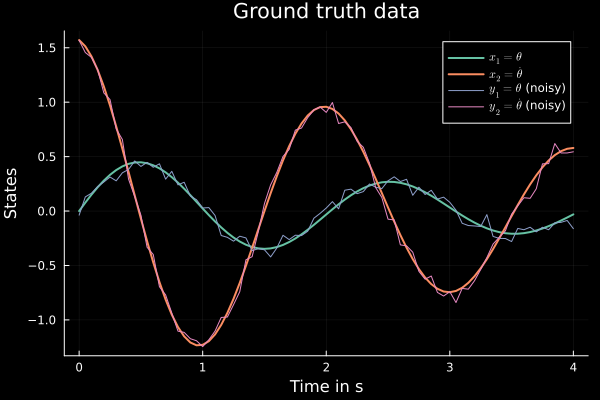

In [7]:
plot(sol.t,reduce(hcat,x)',label=[L"$x_1=\theta$" L"$x_2=\dot{\theta}$"],xlabel="Time in s",ylabel="States",title="Ground truth data", lw=2,background_color="#000000", palette = :Set2_5)
plot!(sol.t,y',label=[L"$y_1=\theta$ (noisy)" L"$y_2=\dot{\theta}$ (noisy)"])

Next, we are starting the parameter identification procedure. While typically the pendulum's length $L$ and mass $m$ can be well measured and the standard gravity acceleration $g$ is also generally known, the **friction coefficient $b$ often remains a rather delicate parameter** which is not easy to determine using a first principle approach.

Hence, we will set up an optimization-based parameter identification procedure using the prediction error method (PEM) to retrieve information regarding $b$. As a first starting point, we will reintroduce the ODE model with by making use of the parameter argument $p$. 

In [8]:
function simplependulum_train_friction!(dx,x,p,t)
    dx[1] = x[2]
    dx[2] = -(g/L)*sin(x[1]) - p[1]/m*x[2]
    nothing
end;

Based on that, we define a least squares cost function which will evaluate the model versus data residuals for some given $b$ value.

In [9]:
prob = ODEProblem(simplependulum_train_friction!, x0, tspan, [1.0]);
function costs(w, y, f)
    newprob = remake(f, p = w) # create an updated ODE problem with new parameters
    sol = solve(newprob,Tsit5(),saveat=0.05)
    x = reduce(hcat,sol.u)    
    return sum(abs2.(y .- x)) # return the sum of squared errors
end;

Finally, we are solving for the least squares fit on $b$ using Newton's method.

In [10]:
res = optimize(w -> costs(w, y, prob), [1.0], Newton(), Optim.Options(show_trace = true, extended_trace = true); autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.770891e+01     1.967324e+01
 * Current step size: 1.0
 * time: 0.015000104904174805
 * g(x): [19.6732420167474]
 * h(x): [-21.80420058487693;;]
 * x: [1.0]
     1     4.187981e-01     2.562156e+00
 * Current step size: 0.8201181798603179
 * time: 1.4530000686645508
 * g(x): [2.5621564566417474]
 * h(x): [261.22536586235276;;]
 * x: [0.2600332503858467]
     2     4.065479e-01     3.907062e-03
 * Current step size: 0.9614004953715043
 * time: 1.4530000686645508
 * g(x): [0.003907061641284987]
 * h(x): [281.6334553296663;;]
 * x: [0.2506036206157705]
     3     4.065479e-01     2.586714e-11
 * Current step size: 1.0000275286075744
 * time: 1.4530000686645508
 * g(x): [2.5867141761892753e-11]
 * h(x): [16.78193836628136;;]
 * x: [0.25058974737335804]


 * Status: success

 * Candidate solution
    Final objective value:     4.065479e-01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.39e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.54e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.74e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.75e-08 ≰ 0.0e+00
    |g(x)|                 = 2.59e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    3
    f(x) calls:    12
    ∇f(x) calls:   12
    ∇²f(x) calls:  3


In [11]:
# Print the found parameter result and compare to ground truth
println("Found parameter: ", res.minimizer)
println("Ground truth: ", b)

Found parameter: [0.25058974737335804]
Ground truth: 0.25


Let's plot the system response of the model using the found friction parameter vs. the noisy ground truth

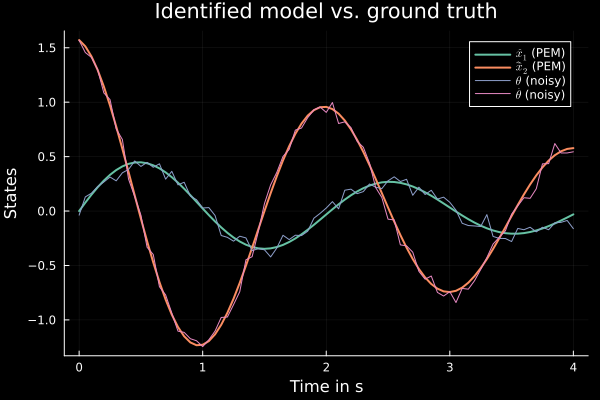

In [12]:
# 
newprob = remake(prob, p = res.minimizer)
sol = solve(newprob,Tsit5(),saveat=0.05)
x = reduce(hcat,sol.u)
plot(sol.t,x',label=[L"$\hat{x}_1$ (PEM)" L"$̂\hat{x}_2$ (PEM)"],xlabel="Time in s",ylabel="States",title="Identified model vs. ground truth", lw=2,background_color="#000000", palette = :Set2_5)
plot!(sol.t,y',label=[L"$\theta$ (noisy)" L"$\dot{\theta}$ (noisy)"])

To analyze why the solver was able to quickly find the correct parameter value within just a few iterations we will inspect the cost surve.

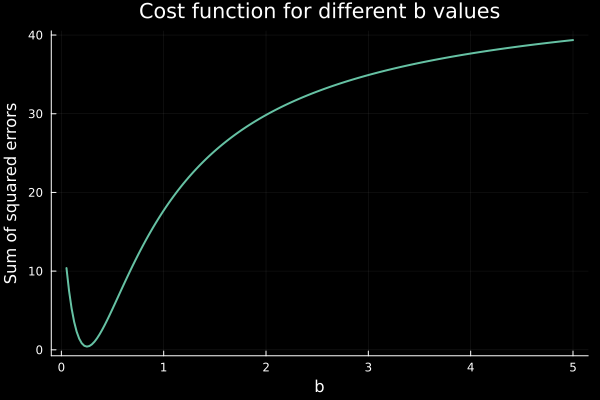

In [13]:
b_vec = LinRange(0.05, 5, 200) # create a vector of b values
cost_vec = zeros(length(b_vec))
for ii = 1:length(b_vec) # loop over all b values
    cost_vec[ii] = costs([b_vec[ii]], y, prob)
end

plot(b_vec, cost_vec, lw=2, background_color="#000000", palette = :Set2_5 ,legend=false) # plot the cost function
xlabel!("b")
ylabel!("Sum of squared errors")
title!("Cost function for different b values")


For curiosity reasons, lets benchmark how long the actual parameter identification procedures takes.

In [14]:
@benchmark res = optimize(w -> costs(w, y, prob), [1.0], Newton(), Optim.Options(show_trace = false); autodiff=:forward)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  324.300 μs …  14.931 ms  ┊ GC (min … max): 0.00% … 95.72%
 Time  (median):     406.350 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   466.271 μs ± 637.106 μs  ┊ GC (mean ± σ):  6.21% ±  4.47%

    ▄█▂                                                          
  ▁▄███▆▃▃▄▇▇▅▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  324 μs           Histogram: frequency by time            1 ms <

 Memory estimate: 350.31 KiB, allocs estimate: 2649.

That's really neat: multiple Newton steps including the underlying numerical ODE solutions (plus evaluating the gradient and Hessian) in less than 1 ms. Here, the option `autodiff=:forward` allows use to make use of [algorithmic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), that is, applying the chain rule of partial derivatives through the programming code (in our case through the least squares cost function, the ODE solver and the ODE problem).

In contrast, using [finite differences](https://en.wikipedia.org/wiki/Finite_difference), that is, a numerical approximation of the gradient and Hessian, requires significant more function evaluations, time and memory:

In [15]:
res = optimize(w -> costs(w, y, prob), [1.0], Newton(), Optim.Options(show_trace = true, extended_trace = true); autodiff=:finite)

Iter     Function value   Gradient norm 
     0     1.770907e+01     1.967341e+01
 * Current step size: 1.0
 * time: 0.0
 * g(x): [19.673408523441903]
 * h(x): [-21.774887800216675;;]
 * x: [1.0]
     1     4.192887e-01     2.615014e+00
 * Current step size: 0.8187878156743312
 * time: 0.0
 * g(x): [2.6150135513026496]
 * h(x): [260.77184211090207;;]
 * x: [0.2602328269348201]
     2     4.065141e-01     4.172025e-03
 * Current step size: 0.9604817602104176
 * time: 0.0
 * g(x): [0.004172025487125543]
 * h(x): [281.59484677016735;;]
 * x: [0.2506011397158408]
     3     4.065140e-01     2.331069e-06
 * Current step size: 0.9979915534493842
 * time: 0.0
 * g(x): [2.3310687839187647e-6]
 * h(x): [281.6152500472963;;]
 * x: [0.2505863537698454]
     4     4.065140e-01     6.814846e-08
 * Current step size: 0.8432209361513042
 * time: 0.016000032424926758
 * g(x): [-6.814846044958166e-8]
 * h(x): [281.61809373274446;;]
 * x: [0.25058634679008845]
     5     4.065140e-01     1.823938e-06
 *

 * Status: success

 * Candidate solution
    Final objective value:     4.065140e-01

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 5.02e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.86e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.69e-10 ≰ 0.0e+00
    |g(x)|                 = 1.70e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    66
    ∇f(x) calls:   66
    ∇²f(x) calls:  7


In [16]:
@benchmark res = optimize(w -> costs(w, y, prob), [1.0], Newton(), Optim.Options(show_trace = false); autodiff=:finite)

BenchmarkTools.Trial: 1004 samples with 1 evaluation.
 Range (min … max):  3.376 ms … 36.258 ms  ┊ GC (min … max): 0.00% … 76.95%
 Time  (median):     4.601 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.962 ms ±  2.805 ms  ┊ GC (mean ± σ):  7.71% ± 11.38%

  █▅  ▄▂                                                      
  ██▆▇██▇▅▅▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂ ▃
  3.38 ms        Histogram: frequency by time        21.6 ms <

 Memory estimate: 3.47 MiB, allocs estimate: 29592.